In [162]:
#derivate=f(x+h)-f(x)/h
h=1e-20

f=lambda x :x*x

# def f(x): return x*x

df= lambda x: (f(x+h)-f(x))/h


df(3)


0.0

In [163]:
# fx=x^2 
# df = 2x

#x=3
#df=2*3=6

In [164]:
3+2

5

In [165]:
#pip install graphviz

In [166]:
# %conda install conda-forge::graphviz

In [167]:
from typing import Union
from graphviz import Digraph
class Value:
    def __init__(self,val:Union[int,float],_children=(),label="",_op=""):
        self.val:Union[int,float]=val
        self.grad:float=0
        self._children=_children
        self.label=label
        self._op=_op
        self._backward=None

    def __repr__(self) -> str:
         return f"{self.label} || Value :  {self.val} | Grad : {self.grad}"
    
    def __add__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other=Value(other)
        out=Value(self.val+other.val,_children=(self,other),_op="+")
        def _backward():
            self.grad+=1*out.grad
            other.grad+=1*out.grad
        out._backward=_backward
        return out
        
    def __sub__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
             other= Value(other)
        out=Value(self.val-other.val,_children=(self,other),_op="-")
        def _backward():
            self.grad+=1*out.grad
            other.grad+=-1*out.grad
        out._backward=_backward
        return out

    def __mul__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other=Value(other)
        out=Value(self.val*other.val,_children=(self,other),_op="*")
        def _backward():
            self.grad+=other.val*out.grad
            other.grad+=self.val*out.grad
        out._backward=_backward
        return out


    def __truediv__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other=Value(other)
        out=Value(self.val/other.val,_children=(self,other),_op="/")
        def _backward():
            self.grad+=(1/other.val)*out.grad    
            import math
            other.grad+=self.val*math.log(other.val)       
        out._backward=_backward
        return out
        
    def __radd__(self,other:Union[int,float,'Value'])->'Value':
            return self+other
    
    def __rmul__(self,other:Union[int,float,'Value'])->'Value':
        return self*other

    def __rsub__(self,other:Union[int,float,'Value'])->'Value':
        return self-other
    
    def __pow__(self,other:Union[int,float])->'Value':
        assert isinstance(other,(int,float)),"Error , power fn only supports integers and floats"
        out=Value(self.val**other,_children=(self,),_op="**")
        def _backward():
            self.grad=other*(self.val**(other-1))*out.grad
        out._backward=_backward
        return out
    
    def tanh(self)->'Value':
        import numpy as np
        out=Value(np.tanh(self.val), _op="tanh",_children=(self,))
        def _backward():
            self.grad+=(1-out.val**2)*out.grad
        out._backward=_backward
        return out

    def _topo_sort(self):
        visited=set()
        stack=[]
        def visit(node):
            if node not in visited:
                visited.add(node)
                for child in node._children:
                    visit(child)
                stack.append(node)
        visit(self)
        return reversed(stack)

    def backward(self):
        self.grad=1
        nodes=self._topo_sort()
        for node in nodes:
            if node._backward:
                node._backward()

    def zero_grad(self):
        self.grad=0
        nodes=self._topo_sort()
        for node in nodes:
            node.grad=0

    def _get_edges_nodes(self):
        edges=set()
        nodes=set()
        def dfs(node):
            if node not in nodes:
                for child in  node._children:
                    edges.add((child,node))
                    dfs(child)
                nodes.add(node)
        dfs(self)
        return nodes,edges

    def graph(self):
        graph=Digraph(format="svg",graph_attr={'rankdir':'LR'})
        nodes,edges=self._get_edges_nodes()
        for node in nodes:
            node_id=str(id(node))
            graph.node(name=node_id,label=f"{node.label} | value = {node.val} | grad = {node.grad}",shape="box")
            if node._op:
                op_id=node_id+node._op
                graph.node(name=op_id,label=node._op,shape="circle")
                graph.edge(op_id,node_id)

        for node1,node2 in edges:
            n1_id=str(id(node1))
            n2_id=str(id(node2)) +node2._op
            graph.edge(n1_id,n2_id)
        return graph
        

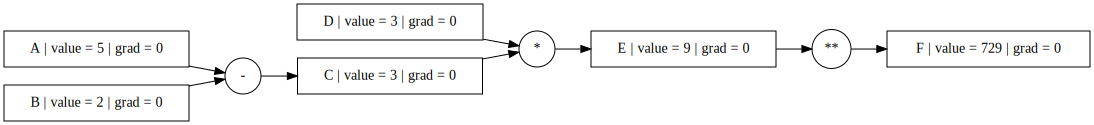

In [168]:
a=Value(5,label='A')
b=Value(2,label='B')
c=a-b;c.label='C';
d=Value(3,label='D')
e=c*d
e.label="E"
f=e**3
f.label='F'
f.graph()

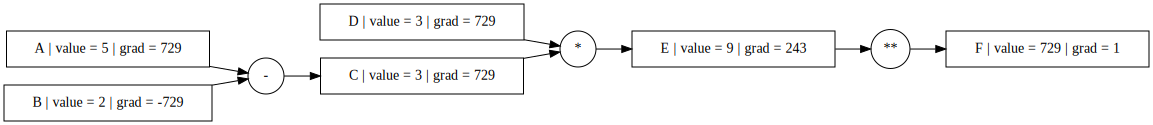

In [169]:
f.backward()
f.graph()

In [170]:
import numpy as np
class Nn:
    def __init__(self):
        self.w00=Value(np.random.rand(),label="w00")
        self.w01=Value(np.random.rand(),label="w11")
        self.b0=Value(np.random.rand(),label="b0")
        self.w10=Value(np.random.rand(),label="w10")
        self.w11=Value(np.random.rand(),label="w11")
        self.b1=Value(np.random.rand(),label="b1")
        self.w20=Value(np.random.rand(),label="w20")
        self.w21=Value(np.random.rand(),label="w21")
        self.b2=Value(np.random.rand(),label="b2")
        self.lr=1e-5
        print("Intial weights & biases")
        print(" w00 : ",self.w00.val)
        print(" w01 : ",self.w01.val)
        print(" b0 : ",self.b0.val)
        print(" w10 : ",self.w10.val)
        print(" w11 : ",self.w11.val)
        print(" b1 : ",self.b1.val)
        print(" w20 : ",self.w20.val)
        print(" w21 : ",self.w21.val)
        print(" b2 : ",self.b2.val)

    def forward(self,x0,x1):
        if isinstance(x0,(float,int)):
            x0=Value(x0)
        x0.label="bark"
        if isinstance(x1,(float,int)):
            x1=Value(x1)
        x1.label="drink milk"
        h0=self.w00*x0+self.w10*x1+self.b0
        h0=h0.tanh();h0.label="h0";
        h1=self.w01*x0+self.w11*x1+self.b1
        h1=h1.tanh();h1.label="h1";
        out=h0*self.w20+h1*self.w21+self.b2
        out=out.tanh()
        out.label="is dog";
        return out
    
    def learn(self):
        self.w00.val-=self.w00.grad*self.lr
        self.w01.val-=self.w01.grad*self.lr
        self.b0.val-=self.b0.grad*self.lr
        self.w10.val-=self.w10.grad*self.lr
        self.w11.val-=self.w11.grad*self.lr
        self.b1.val-=self.b1.grad*self.lr
        self.w20.val-=self.w20.grad*self.lr
        self.w21.val-=self.w21.grad*self.lr
        self.b2.val-=self.b2.grad*self.lr

In [171]:
nn=Nn()

Intial weights & biases
 w00 :  0.9588281010838022
 w01 :  0.7777181946262973
 b0 :  0.8882090808242519
 w10 :  0.13493338195315963
 w11 :  0.25430268067969264
 b1 :  0.025974870982907183
 w20 :  0.982441818411988
 w21 :  0.16603300541558197
 b2 :  0.9351024098834678


In [172]:
x0=Value(0.9);# bark
x1=Value(0.3);#drink milk
out=nn.forward(x0,x1)
print("prob to bark : ",x0.val)
print("prob to drink milk : ",x1.val)
print("output : prob of being dog : ",out.val)

prob to bark :  0.9
prob to drink milk :  0.3
output : prob of being dog :  0.9622094295853735


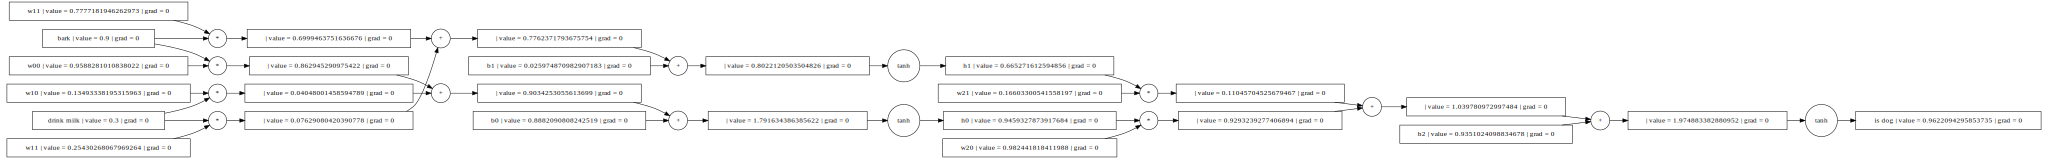

In [173]:
out.graph()

Expected output : 0.86  | output recieved : 0.96 | error : 0.10
Expected output : 0.79  | output recieved : 0.96 | error : 0.17
Expected output : 0.95  | output recieved : 0.96 | error : 0.01
Expected output : 0.22  | output recieved : 0.95 | error : 0.73
Expected output : 0.45  | output recieved : 0.95 | error : 0.50
Root mean square error : 36.44


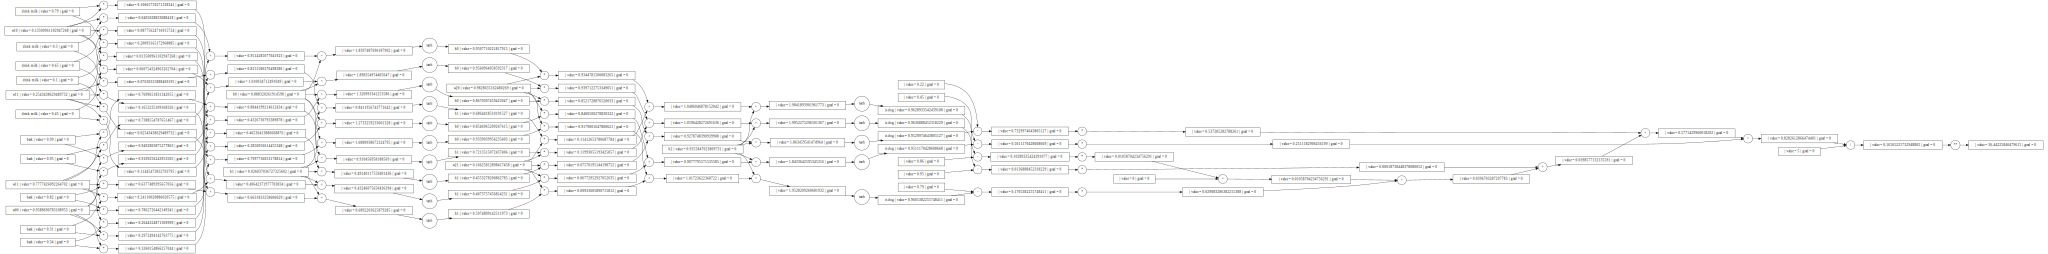

In [180]:
# (bark,drink_milk,is_dog)
data = [(0.95,0.3,0.86),
 (0.82,0.1,0.79),
 (0.99,0.45,0.95),
 (0.34,0.79,0.22),
 (0.31,0.65,0.45),
 ]

sq_error_sum=0
for (bark,milk,is_dog) in data:
    out=nn.forward(bark,milk)
    error=is_dog-out
    sq_error_sum+=error*error
    print(f"Expected output : {is_dog}  | output recieved : {out.val:.2f} | error : {error.val:.2f}")
mean_sq_error=sq_error_sum/len(data)
rms_error=mean_sq_error**-2
print(f"Root mean square error : {rms_error.val:.2f}")

rms_error.zero_grad()
rms_error.graph()

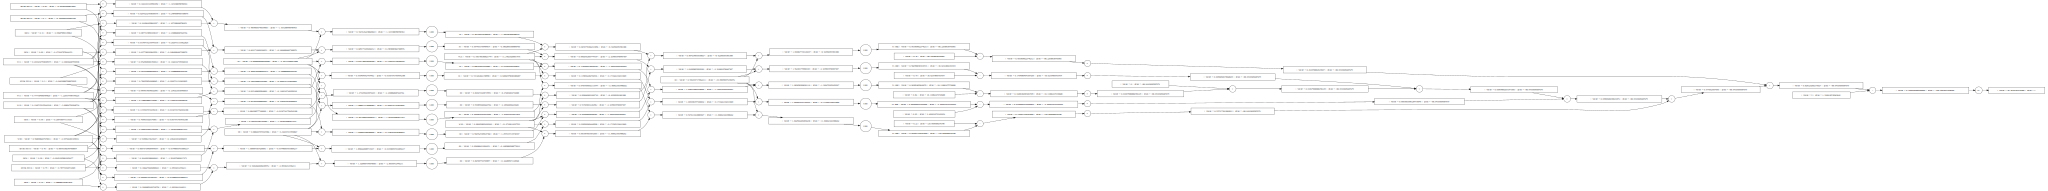

In [178]:
rms_error.backward()
rms_error.graph()

In [179]:
nn.learn()